In [1]:
import pandas as pd
from typing import List
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

mpl.rcParams["font.family"] = "serif"
mpl.rcParams["font.serif"] = "Ubuntu"
mpl.rcParams["font.monospace"] = "Ubuntu Mono"
mpl.rcParams["font.size"] = 14
mpl.rcParams["axes.labelsize"] = 14
mpl.rcParams["axes.labelweight"] = "bold"
mpl.rcParams["xtick.labelsize"] = 14
mpl.rcParams["ytick.labelsize"] = 14
mpl.rcParams["legend.fontsize"] = 14
mpl.rcParams["figure.titlesize"] = 16

In [2]:
def preprocess(
    filename: str = "_chat.txt",
    delimiters: List[str] = ["\[", "\] ", ": "],
    friends_names: List[List[str]] = [],
) -> pd.DataFrame:
    """
    Converts exported Whatsapp chat .txt files to Pandas DataFrames.
    Each row (by default) has shape:
        [date, time] sender name: message
    So, by splitting on "[", "]" and ": ", and keeping only cols 2 (date + time) and 3 (name),
    we can extract some useful info. Note that square brackets need to be escaped with "\", and that
    the spaces added for ": " are to prevent separating 23:15:22, for example.
    Also do some cleaning based on valid dates, unicode chars and your friends' names (including aliases).
    """
    # Create regex for delimiters
    del_regex = "|".join(delimiters)
    
    # Load as .csv (even though the file technically isn't a .csv)
    data = pd.read_csv(
        filename, sep=del_regex, usecols=[1, 2], names=["date_time", "name"], engine="python")
    
    # Convert to datetime, set fields with invalid dates to NaT, so we can drop these rows later
    data["date_time"] = pd.to_datetime(data["date_time"], errors="coerce", format="%d/%m/%Y, %H:%M:%S")
    
    # Delete rows where we have missing data (e.g., because someone used a line break in their message)
    data = data.dropna(axis=0, how="any")
    
    # Delete rows that contain group name changes, new admins, people changing phone numbers, etc.
    # These use the unicode character "\u200e"
    data = data[~data["name"].str.contains("\u200e")]
    
    # Merge friends with aliases (e.g., because they changed phone numbers)
    # and discard rows with invalid names.
    flat_friends = [alias for friend in friends_names for alias in friend]
    data = data[data["name"].isin(flat_friends)]
    
    for friend in friends_names:
        for alias in friend[1:]:
            data.loc[data["name"] == alias, "name"] = friend[0]
    
    return data

In [3]:
friends_names = [
    ["frienda"],
    ["friendb"],
    ["friendc"],
    ["friendd"],
    ["friende"],
    ["friendf"],
    ["friendg"],
    ["friendh"],
    ["friendi"],
]
whatsapp = preprocess(friends_names=friends_names)
whatsapp.head()

,date_time,name
0,2015-05-19 23:15:22,frienda
1,2015-05-19 23:15:30,frienda
2,2015-06-19 19:06:31,friendb
3,2015-06-19 19:20:12,friendh
4,2015-06-19 19:20:45,friendi


In [4]:
whatsapp["name"].unique()

array(['frienda', 'friendb', 'friendh', 'friendi', 'friendd', 'friendc',
       'friende', 'friendf', 'friendg'], dtype=object)

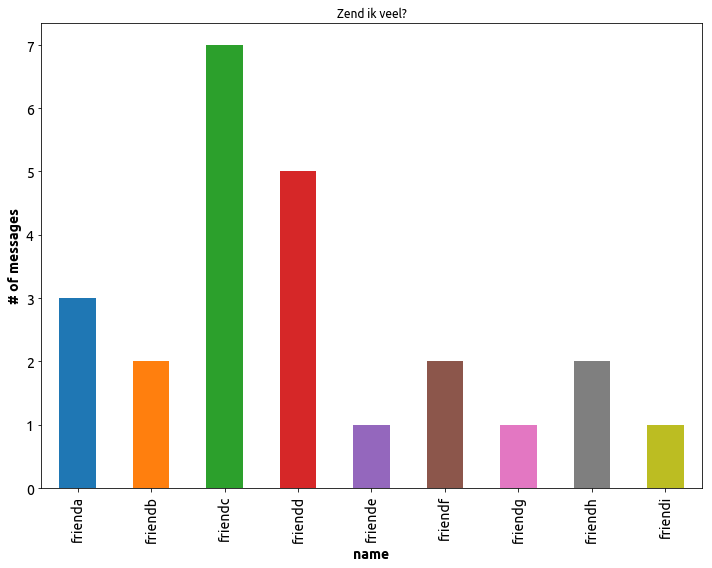

In [5]:
# Plot with nr of messages per sender
activity = whatsapp.groupby("name")["date_time"].nunique()
activity_plot = activity.plot.bar(x="name", y="date_time", title="Zend ik veel?")
activity_plot.set_ylabel("# of messages");
figure = activity_plot.get_figure()
figure.set_size_inches(10, 8)
figure.tight_layout()
figure.savefig("activity.png", dpi=300)

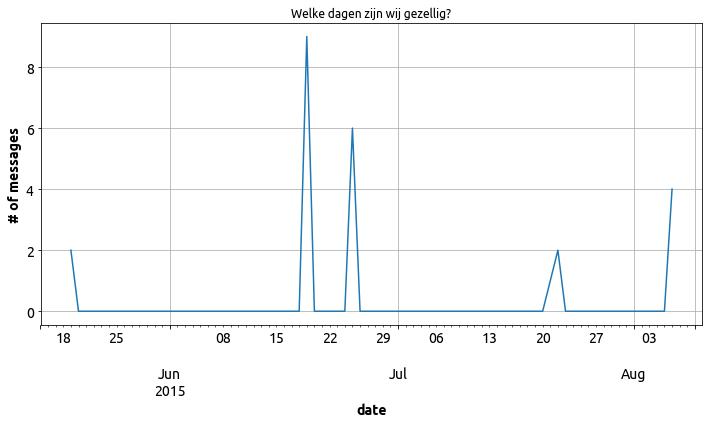

In [6]:
# Plot with messages per day
activity_day = whatsapp.groupby(pd.Grouper(key="date_time", freq="D"))["date_time"].nunique()
activity_day_plot = activity_day.plot.line(x="date_time", y="date_time", title="Welke dagen zijn wij gezellig?")
activity_day_plot.set_xlabel("date")
activity_day_plot.set_ylabel("# of messages");
activity_day_plot.grid(True)
figure = activity_day_plot.get_figure()
figure.set_size_inches(10, 6)
figure.tight_layout()
figure.savefig("activity_day.png", dpi=300)

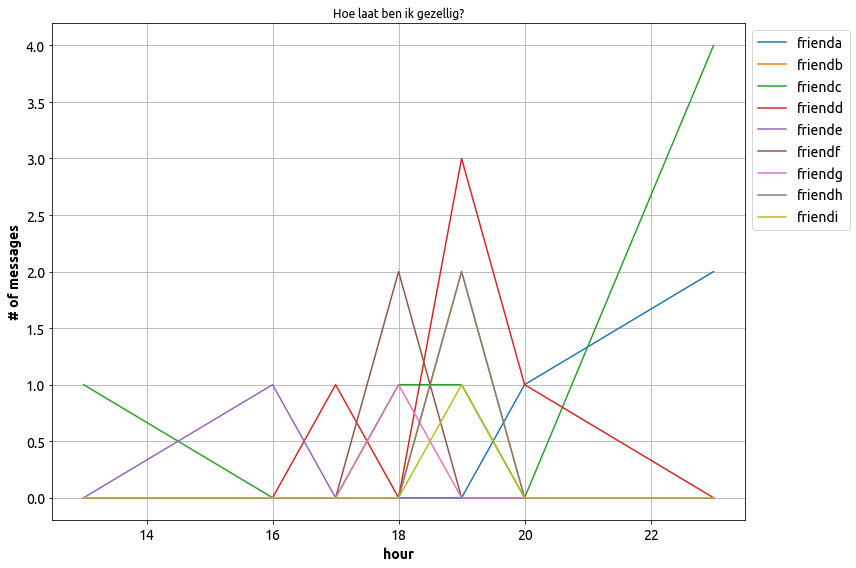

In [7]:
# Plot with messages per hour of day
whatsapp["hour"] = whatsapp["date_time"].dt.hour
activity_hour = whatsapp.groupby(["hour", "name"])["date_time"].nunique().unstack()
activity_hour = activity_hour.fillna(0)
activity_hour_plot = activity_hour.plot.line(title="Hoe laat ben ik gezellig?")
activity_hour_plot.set_ylabel("# of messages");
activity_hour_plot.grid(True)
activity_hour_plot.legend(bbox_to_anchor=(1, 1));
figure = activity_hour_plot.get_figure()
figure.set_size_inches(12, 8)
figure.tight_layout()
figure.savefig("activity_hour.png", dpi=300)